In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
from plotnine import aes, ggplot
import pathlib
from datetime import datetime
import xlrd
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


# Import Datasets

Data from the following places will be used. I choose a to use only data from 2021-2023

- CPI (https://stats.oecd.org/index.aspx?DataSetCode=PRICES_CPI#)
- dollar (https://ru.investing.com/currencies/usd-zar-historical-data)
- petrol prices (https://www.energy.gov.za/files/esources/petroleum/petroleum_arch.html)

In [2]:
# get directory path
path = str(pathlib.Path().cwd().parent.parent.resolve())

In [3]:
cpi = pd.read_csv(path + '/data/PRICES_CPI_11062023152547285.csv')
dollar = pd.read_csv(path + '/data/DEXSFUS.csv', delimiter=';')
fuel_2021 = pd.read_csv(path + '/data/Basic-Fuel-Price2021.csv', delimiter=';')
fuel_2022 = pd.read_csv(path + '/data/Basic-Fuel-Price2022.csv', delimiter=';')
fuel_2023 = pd.read_csv(path + '/data/Basic-Fuel-Price2023.csv', delimiter=';')

fuel_2021['year'] = '2021'
fuel_2022['year'] = '2022'
fuel_2023['year'] = '2023'

fuel = pd.concat([fuel_2022[['Petrol 93\r\nUnleaded', 'year', 'RSAc/litre']], fuel_2021[['Petrol 93\r\nUnleaded', 'year', 'RSAc/litre']], fuel_2023[['Petrol 93\r\nUnleaded', 'year', 'RSAc/litre']]])

# EDA
## View CPI

In [4]:
cpi_columns = {'Food and non-Alcoholic beverages' : 'Food', 
               'All items': 'CPI',
               'Alcoholic beverages, tobacco and narcotics': 'Alcohol',
               'Clothing and footwear': 'Clothes',
               'Housing, water, electricity, gas and other fuels': 'Household', 
               'Transport': 'Transport',
               'Recreation and culture': 'Recreation', 
               'Health': 'Health',
               'Furnishings, household equipment and routine household maintenance': 'Furnishings',
               'Communication': 'Communication',
               'Education': 'Education',
               'Restaurants and hotels': 'Restaurants', 
               'Miscellaneous goods and services': 'Other services'}

In [5]:
# Select only where measure in Index
cpi = cpi[cpi['Measure'] == 'National Index']

In [6]:
# get categories
cpi['cpi_cat'] = cpi['Subject'].apply(lambda x: x.split('- ')[-1])
cpi = cpi[cpi['cpi_cat'].isin(cpi_columns)][['Time', 'cpi_cat', 'Value']]

In [7]:
# change month to datetime format
cpi['Date'] = pd.to_datetime(cpi['Time']).dt.strftime('%Y-%m')

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_57576/3347956333.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [8]:
# map categories to shorter names
cpi = cpi.replace(cpi_columns)

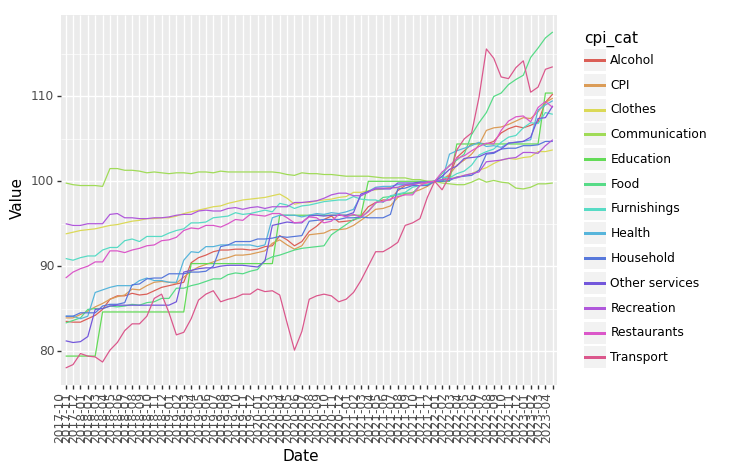

<ggplot: (350934010)>

In [9]:
(ggplot(cpi) + 
pn.geom_line(aes(x='Date', y='Value', color='cpi_cat', group='cpi_cat')) + 
pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)))

In [10]:
cpi = cpi.loc[(cpi['Date'] >= '2021-12-31')]

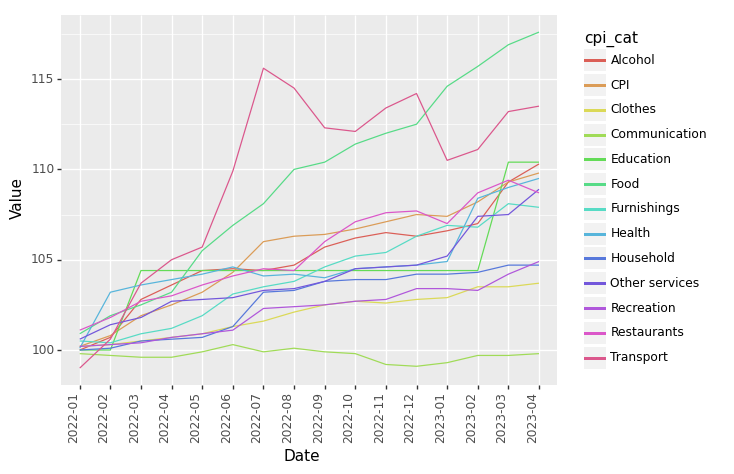

<ggplot: (351159534)>

In [11]:
(ggplot(cpi) + 
pn.geom_line(aes(x='Date', y='Value', color='cpi_cat', group='cpi_cat')) + 
pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)))

# Add Fuel and Dollar

In [12]:
fuel['Time'] = fuel['RSAc/litre'] + '-' + fuel['year']

# # change month to datetime format
fuel['Date'] = pd.to_datetime(fuel['Time']).dt.strftime('%Y-%m')
fuel.columns = ['Petrol', 'year', 'month', 'Time', 'Date']
dollar['Date'] = pd.to_datetime(dollar['DATE'], format='%d.%m.%Y').dt.strftime('%Y-%m')
dollar['Dollar'] = dollar['PRICE'].apply(lambda x: float(x.replace(',', '.')))
dollar.columns = ['Time', 'PRICE', 'Date', 'Dollar']
dollar = dollar[['Date', 'Dollar']].groupby(['Date'])['Dollar'].agg('mean').to_frame().reset_index()

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_57576/3799672639.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [13]:
# correct some incorrect data in fuel prices
fuel['Petrol'] = [float(str(x).replace(' ', '')) for x in fuel['Petrol']]

In [14]:
df_all = pd.merge(cpi, dollar[['Dollar', 'Date']], on='Date', how='left')
df_all = pd.merge(df_all, fuel[['Petrol', 'Date']], on='Date', how='left')

# Model

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [27]:
df_hw_pred = []

for cat in cpi_columns.values():
    data = df_all[df_all['cpi_cat']==cat]['Value'].values
    model = ExponentialSmoothing(data, trend='add')
    model_fit = model.fit(optimized=True)
    yhat = model_fit.forecast(2)
    df_hw_pred.append({'Time':'June-2023', 'cpi_cat':cat, 'Value':yhat[0]})

In [28]:
df_june = pd.DataFrame(df_hw_pred)

# Get submission

In [29]:
df_sub = df_june[['cpi_cat', 'Value']]
df_sub.columns = ['ID', 'Value']

In [30]:
month = 'June'

In [31]:
pred_map = {'CPI': f'{month}_headline CPI',
'Alcohol': f'{month}_alcoholic beverages and tobacco',
'Clothes': f'{month}_clothing and footwear',
'Communication': f'{month}_communication',
'Education': f'{month}_education',
'Food': f'{month}_food and non-alcoholic beverages',
'Health': f'{month}_health',
'Furnishings': f'{month}_household contents and services',
'Household': f'{month}_housing and utilities',
'Other services': f'{month}_miscellaneous goods and services',
'Recreation': f'{month}_recreation and culture',
'Restaurants': f'{month}_restaurants and hotels',
'Transport': f'{month}_transport'}

In [32]:
df_sub = df_sub.replace(pred_map)

In [34]:
df_sub.to_csv(path + '/submissions/v12_holtwinters.csv', index=False)